In [333]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

import glob

##
import pytz
import datetime as dt
import math
import seaborn as sns

# ---- Skin Conducatnace aand Heart beats per minute

In [334]:
def get_non_nan_values_cols(p_df, col_name):
    
    slic_ind=p_df[col_name].isnull()
    list_ne=slic_ind.tolist()
    false_indices = [i for i in range(len(list_ne)) if not list_ne[i]]
    
    list_col_interest=p_df[col_name].to_list()
    
    non_values_list = []
    
    for false_ind in false_indices:
        non_val = list_col_interest[false_ind]
        non_values_list.append(non_val)
    
    return non_values_list

def get_file_names_from_ind_list(files_list, inds_list):
    
    selected_files_list=[files_list[sel_index] for sel_index in inds_list]
    
    return selected_files_list


def get_sk_hr_std_mean_acc(sk_hr_files_list, condition_files):
    event_interst_col = "event_interst"
    mean_sk_col = "mean_sk_cond"
    std_sk_col ="std_sk_cond"

    mean_hr_col = "mean_hr"
    std_hr_col = "std_hr"

    mean_sk_acc=[]
    std_sk_acc = []

    mean_hr_acc=[]
    std_hr_acc=[]

    for selected_path in sk_hr_files_list:
        dir_path, file_name=os.path.split(selected_path)
        sub_id = file_name[0:12]
        #print(sub_id)
        for cond_file in condition_files:
            if sub_id==cond_file:
                #print(selected_path)
                sk_hr_df = pd.read_csv(selected_path)

                mean_sk = sk_hr_df[mean_sk_col].values
                std_sk = sk_hr_df[std_sk_col].values
                mean_hr =sk_hr_df[mean_hr_col].values
                std_hr =sk_hr_df[std_hr_col].values


                mean_sk_acc.append(mean_sk)
                std_sk_acc.append(std_sk)
                mean_hr_acc.append(mean_hr)
                std_hr_acc.append(std_hr)



    mean_mean_sk=np.mean(np.array(mean_sk_acc), axis=0) 
    #std_mean_sk = np.std(np.array(std_sk_acc), axis=0)
    std_mean_sk = np.mean(np.array(std_sk_acc), axis=0)

    mean_mean_hr=np.mean(np.array(mean_hr_acc), axis=0) 
    #std_mean_hr = np.std(np.array(std_hr_acc), axis=0)
    std_mean_hr = np.mean(np.array(std_hr_acc), axis=0)
    
    selected_events = sk_hr_df[event_interst_col].to_list()
    
    extracted_data={"selected_event": selected_events, "hr_mean": mean_mean_hr, "hr_std": std_mean_hr, "sk_mean": mean_mean_sk, "sk_std":std_mean_sk}
    
    return extracted_data




def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    #plt.ylim(0, 1) 
    plt.tight_layout()
    plt.show()
    return fig
    

In [335]:
sub_data_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/subjective_data/subjective_data.xlsx"
hrv_data_dir = "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis"
sk_hr_data_dir_norm ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/normalized"

In [336]:
sk_hr_files_list = glob.glob(sk_hr_data_dir_norm+ "/*.csv")

In [337]:
sub_data_df=pd.read_excel(sub_data_path)
file_col = "subject"
cond_col ="condition"

file_list = get_non_nan_values_cols(sub_data_df,file_col)
cond_list = get_non_nan_values_cols(sub_data_df, cond_col)

cond_set=set(cond_list)
unique_conds_list= list(cond_set)

In [338]:
print(unique_conds_list)

['2D_no_scent', '2D_scent', 'VR_no_scent', 'VR_scent']


In [339]:
no_scent_2d_inds=np.where(np.array(cond_list)=="2D_no_scent")
no_scent_2d_inds = list(no_scent_2d_inds[0])
no_scent_2d_files =get_file_names_from_ind_list(file_list, no_scent_2d_inds)

scent_2d_inds=np.where(np.array(cond_list)=="2D_scent")
scent_2d_inds=list(scent_2d_inds[0])
scent_2d_files=get_file_names_from_ind_list(file_list, scent_2d_inds)

no_scent_vr_inds = np.where(np.array(cond_list)=="VR_no_scent")
no_scent_vr_inds=list(no_scent_vr_inds[0])
no_scent_vr_files=get_file_names_from_ind_list(file_list, no_scent_vr_inds)

scent_vr_inds =np.where(np.array(cond_list)=="VR_scent")
scent_vr_inds =list(scent_vr_inds[0])
scent_vr_files=get_file_names_from_ind_list(file_list, scent_vr_inds)

In [340]:
scent_vr_files[0]

'VP006_091123'

#  scent_vr

In [341]:
scent_vr_dict=get_sk_hr_std_mean_acc(sk_hr_files_list,scent_vr_files)     

In [342]:
scent_vr_dict

{'selected_event': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min',
  'saliva_probe_4_ts -5 min',
  'saliva_probe_4_ts 5 min'],
 'hr_mean': array([0.57676916, 0.71149258, 0.74995716, 0.72569076, 0.56575982,
        0.57113396, 0.57523052, 0.60211298, 0.59861656]),
 'hr_std': array([0.0337557 , 0.0572898 , 0.05776997, 0.05142718, 0.04270994,
        0.03898709, 0.04201185, 0.05420521, 0.0532749 ]),
 'sk_mean': array([0.10286979, 0.49856627, 0.54009283, 0.47595467, 0.17992302,
        0.10939372, 0.07897647, 0.16481513, 0.23077968]),
 'sk_std': array([0.05697564, 0.0783207 , 0.06929342, 0.03943235, 0.03823563,
        0.01711356, 0.01155986, 0.04774162, 0.02739232])}

# no_scent_vr 

In [343]:
no_scent_vr_dict=get_sk_hr_std_mean_acc(sk_hr_files_list,no_scent_vr_files)

In [344]:
no_scent_vr_dict

{'selected_event': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min',
  'saliva_probe_4_ts -5 min',
  'saliva_probe_4_ts 5 min'],
 'hr_mean': array([0.63303291, 0.71190637, 0.76632629, 0.73108994, 0.604752  ,
        0.60852443, 0.59714816, 0.6181088 , 0.65168845]),
 'hr_std': array([0.03541572, 0.05250984, 0.06067125, 0.05253495, 0.04130477,
        0.0408336 , 0.04133961, 0.06695969, 0.05753302]),
 'sk_mean': array([0.21780845, 0.41985767, 0.47055217, 0.4213177 , 0.24738313,
        0.17351694, 0.12720588, 0.21324772, 0.24255177]),
 'sk_std': array([0.06951027, 0.05555909, 0.04744932, 0.04085825, 0.03735894,
        0.0353285 , 0.03209244, 0.0627473 , 0.05013337])}

# 2d with scent

In [345]:
scent_2d_dict=get_sk_hr_std_mean_acc(sk_hr_files_list, scent_2d_files)

In [346]:
scent_2d_dict

{'selected_event': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min',
  'saliva_probe_4_ts -5 min',
  'saliva_probe_4_ts 5 min'],
 'hr_mean': array([0.42820752, 0.59216272, 0.73453458, 0.66577386, 0.41290398,
        0.4034281 , 0.40956334, 0.46273189, 0.45973487]),
 'hr_std': array([0.02948172, 0.04967202, 0.10919878, 0.07189075, 0.02764967,
        0.02153521, 0.02831238, 0.05725997, 0.046715  ]),
 'sk_mean': array([0.08512112, 0.58631609, 0.53140991, 0.46425453, 0.29532717,
        0.17572186, 0.22645593, 0.42903631, 0.42588735]),
 'sk_std': array([0.05610024, 0.08136648, 0.06493673, 0.04579895, 0.04247118,
        0.03609988, 0.08647393, 0.06389641, 0.04294007])}

# 2d without scent 

In [347]:
no_scent_2d_dict = get_sk_hr_std_mean_acc(sk_hr_files_list, no_scent_2d_files)

In [348]:
no_scent_2d_dict

{'selected_event': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min',
  'saliva_probe_4_ts -5 min',
  'saliva_probe_4_ts 5 min'],
 'hr_mean': array([0.55191541, 0.65268864, 0.71291697, 0.69710665, 0.54917326,
        0.55770876, 0.53717758, 0.56849361, 0.58269673]),
 'hr_std': array([0.02550022, 0.06772303, 0.062614  , 0.06772485, 0.03079126,
        0.0337347 , 0.03390293, 0.07225932, 0.04078309]),
 'sk_mean': array([0.07986936, 0.45925279, 0.50526903, 0.44391326, 0.18774181,
        0.13892077, 0.08244228, 0.19795834, 0.20854638]),
 'sk_std': array([0.03376998, 0.04113929, 0.02846199, 0.0378415 , 0.02154706,
        0.026156  , 0.01051731, 0.0377513 , 0.01737759])}

In [349]:
sk_mean = list(no_scent_2d_dict["sk_mean"])
sk_std = list(no_scent_2d_dict["sk_std"])
x_labels = no_scent_2d_dict["selected_event"]
title_figure = "2-D no-secent conditions"  
y_label_fig = "Normalized Skin Conductance"

# plotting skin conductance

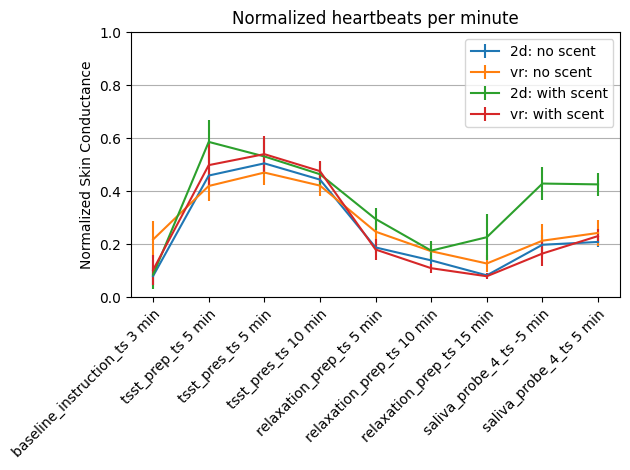

In [350]:
 
x_pos = np.arange(len(x_labels))
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(no_scent_2d_dict["sk_mean"]),  yerr=list(no_scent_2d_dict["sk_std"]), label="2d: no scent" )
ax.errorbar(x_pos,  list(no_scent_vr_dict["sk_mean"]),  yerr=list(no_scent_vr_dict["sk_std"]), label="vr: no scent" )
ax.errorbar(x_pos,  list(scent_2d_dict["sk_mean"]),  yerr=list(scent_2d_dict["sk_std"]), label="2d: with scent")
ax.errorbar(x_pos,  list(scent_vr_dict["sk_mean"]),  yerr=list(scent_vr_dict["sk_std"]), label="vr: with scent")
ax.set_ylabel(y_label_fig)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
#title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()

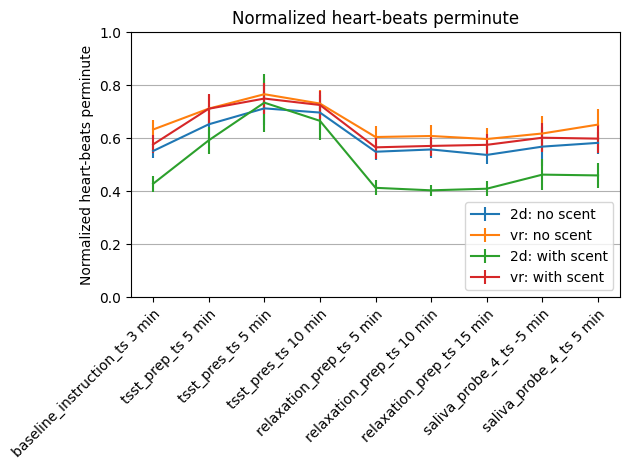

In [351]:

 
x_pos = np.arange(len(x_labels))
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(no_scent_2d_dict["hr_mean"]),  yerr=list(no_scent_2d_dict["hr_std"]), label="2d: no scent" )
ax.errorbar(x_pos,  list(no_scent_vr_dict["hr_mean"]),  yerr=list(no_scent_vr_dict["hr_std"]), label="vr: no scent" )
ax.errorbar(x_pos,  list(scent_2d_dict["hr_mean"]),  yerr=list(scent_2d_dict["hr_std"]), label="2d: with scent")
ax.errorbar(x_pos,  list(scent_vr_dict["hr_mean"]),  yerr=list(scent_vr_dict["hr_std"]), label="vr: with scent")
ax.set_ylabel("Normalized heart-beats perminute")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
#title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

ax.set_title("Normalized heart-beats perminute")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()


# HRV analysis

In [352]:
hrv_data_dir = "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis"

In [353]:
hrv_files_list = glob.glob(hrv_data_dir+ "/*.csv")

In [354]:
hrv_files_list

['/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP012_141123_DigiRelax_Experiment_2023-11-14_09h47.48.508.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP008_101123_DigiRelax_Experiment_2023-11-10_10h24.14.323.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP016_161123_DigiRelax_Experiment_2023-11-16_14h46.57.355.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP007_091123_DigiRelax_Experiment_2023-11-09_14h19.56.411.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP020_221123_DigiRelax_Experiment_2023-11-22_09h48.04.766.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP019_201123_DigiRelax_Experiment_2023-11-20_14h48.37.367.csv',
 '/home/muhammad/Desktop/repos_ixp/teste

In [355]:
sub_data_df=pd.read_excel(sub_data_path)
file_col = "subject"
cond_col ="condition"

file_list = get_non_nan_values_cols(sub_data_df,file_col)
cond_list = get_non_nan_values_cols(sub_data_df, cond_col)

cond_set=set(cond_list)
unique_conds_list= list(cond_set)

In [356]:
no_scent_2d_inds=np.where(np.array(cond_list)=="2D_no_scent")
no_scent_2d_inds = list(no_scent_2d_inds[0])
no_scent_2d_files =get_file_names_from_ind_list(file_list, no_scent_2d_inds)

scent_2d_inds=np.where(np.array(cond_list)=="2D_scent")
scent_2d_inds=list(scent_2d_inds[0])
scent_2d_files=get_file_names_from_ind_list(file_list, scent_2d_inds)

no_scent_vr_inds = np.where(np.array(cond_list)=="VR_no_scent")
no_scent_vr_inds=list(no_scent_vr_inds[0])
no_scent_vr_files=get_file_names_from_ind_list(file_list, no_scent_vr_inds)

scent_vr_inds =np.where(np.array(cond_list)=="VR_scent")
scent_vr_inds =list(scent_vr_inds[0])
scent_vr_files=get_file_names_from_ind_list(file_list, scent_vr_inds)

In [357]:
def get_hrv_std_mean_acc(sk_hr_files_list, condition_files):
    
    event_interst_col = "event_interst"
    #mean_sk_col = "mean_hrv"
    #std_sk_col ="std_hrv"

    mean_hr_col = "norm_mean_hrv"
    std_hr_col = "norm_std_hrv"

    #mean_sk_acc=[]
    #std_sk_acc = []

    mean_hr_acc=[]
    std_hr_acc=[]

    for selected_path in sk_hr_files_list:
        dir_path, file_name=os.path.split(selected_path)
        sub_id = file_name[0:12]
        #print(sub_id)
        for cond_file in condition_files:
            if sub_id==cond_file:
                #print(selected_path)
                sk_hr_df = pd.read_csv(selected_path)

                #mean_sk = sk_hr_df[mean_sk_col].values
                #std_sk = sk_hr_df[std_sk_col].values
                mean_hr =sk_hr_df[mean_hr_col].values
                std_hr =sk_hr_df[std_hr_col].values


                #mean_sk_acc.append(mean_sk)
                #std_sk_acc.append(std_sk)
                mean_hr_acc.append(mean_hr)
                std_hr_acc.append(std_hr)



    #mean_mean_sk=np.mean(np.array(mean_sk_acc), axis=0) 
    ##std_mean_sk = np.std(np.array(std_sk_acc), axis=0)
    #std_mean_sk = np.mean(np.array(std_sk_acc), axis=0)

    mean_mean_hr=np.mean(np.array(mean_hr_acc), axis=0) 
    #std_mean_hr = np.std(np.array(std_hr_acc), axis=0)
    std_mean_hr = np.mean(np.array(std_hr_acc), axis=0)
    
    selected_events = sk_hr_df[event_interst_col].to_list()
    
    extracted_data={"selected_event": selected_events, "hrv_mean": mean_mean_hr, "hrv_std": std_mean_hr}
    
    return extracted_data


In [358]:
scent_vr_dict=get_hrv_std_mean_acc(hrv_files_list, scent_vr_files)
no_scent_vr_dict=get_hrv_std_mean_acc(hrv_files_list,no_scent_vr_files)
scent_2d_dict=get_hrv_std_mean_acc(hrv_files_list, scent_2d_files)
no_scent_2d_dict = get_hrv_std_mean_acc(hrv_files_list, no_scent_2d_files)

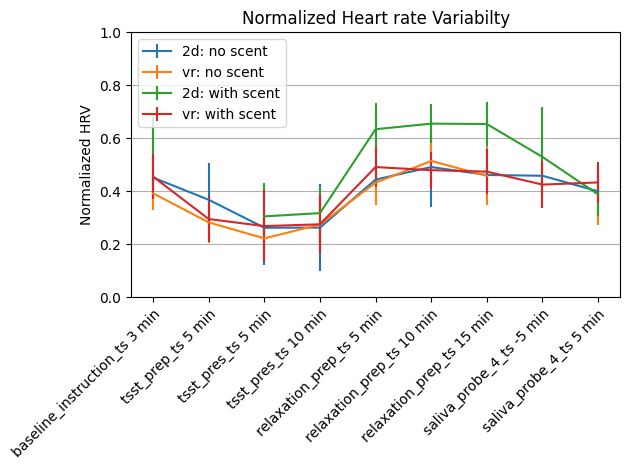

In [385]:

x_pos = np.arange(len(x_labels))
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(no_scent_2d_dict["hrv_mean"]),  yerr=list(no_scent_2d_dict["hrv_std"]), label="2d: no scent" )
ax.errorbar(x_pos,  list(no_scent_vr_dict["hrv_mean"]),  yerr=list(no_scent_vr_dict["hrv_std"]), label="vr: no scent" )
ax.errorbar(x_pos,  list(scent_2d_dict["hrv_mean"]),  yerr=list(scent_2d_dict["hrv_std"]), label="2d: with scent")
ax.errorbar(x_pos,  list(scent_vr_dict["hrv_mean"]),  yerr=list(scent_vr_dict["hrv_std"]), label="vr: with scent")
ax.set_ylabel("Normaliazed HRV")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
#title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

ax.set_title("Normalized Heart rate Variabilty")
ax.yaxis.grid(True)
plt.legend(loc='upper left')
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()

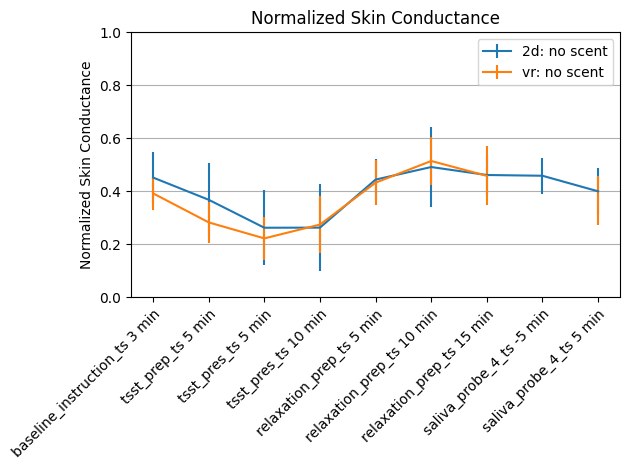

In [363]:

x_pos = np.arange(len(x_labels))
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(no_scent_2d_dict["hrv_mean"]),  yerr=list(no_scent_2d_dict["hrv_std"]), label="2d: no scent" )
ax.errorbar(x_pos,  list(no_scent_vr_dict["hrv_mean"]),  yerr=list(no_scent_vr_dict["hrv_std"]), label="vr: no scent" )
#ax.errorbar(x_pos,  list(scent_2d_dict["hrv_mean"]),  yerr=list(scent_2d_dict["hrv_std"]), label="2d: with scent")
#ax.errorbar(x_pos,  list(scent_vr_dict["hrv_mean"]),  yerr=list(scent_vr_dict["hrv_std"]), label="vr: with scent")
ax.set_ylabel(y_label_fig)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
#title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

ax.set_title("Normalized Skin Conductance")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()

In [364]:
scent_2d_dict["hrv_mean"]

array([0.53728303,        nan, 0.30515358, 0.31736469, 0.63418707,
       0.65519527, 0.65383103, 0.52956861, 0.38805351])

In [365]:
mean_diif_s2d = np.diff(scent_2d_dict["hrv_mean"])


In [366]:
mean_diif_s2d

array([        nan,         nan,  0.0122111 ,  0.31682238,  0.0210082 ,
       -0.00136424, -0.12426242, -0.1415151 ])

In [367]:
mean_diif_s2d = np.insert(mean_diif_s2d, [0], 0)

In [368]:
mean_diif_s2d_cumsum=np.cumsum(mean_diif_s2d, dtype=float) 

In [369]:
mean_diif_s2d_cumsum

array([ 0., nan, nan, nan, nan, nan, nan, nan, nan])

In [370]:
mean_diif_svr = np.diff(scent_vr_dict["hrv_mean"])

In [371]:
def get_cumsum_cond(input_array):
    
    mean_diff = np.diff(input_array)
    
    mean_diff = np.insert(mean_diff, [0], 0)
    
    mean_diff_cumsum = np.cumsum(mean_diff, dtype=float)
    
    return (mean_diff_cumsum)
    
    
    
    
    

In [372]:
hrv_2d_s = get_cumsum_cond(scent_2d_dict["hrv_mean"])
hrv_2d_n=get_cumsum_cond(no_scent_2d_dict["hrv_mean"])


In [373]:
hrv_vr_s = get_cumsum_cond(scent_vr_dict["hrv_mean"])
hrv_vr_n =get_cumsum_cond(no_scent_vr_dict["hrv_mean"])

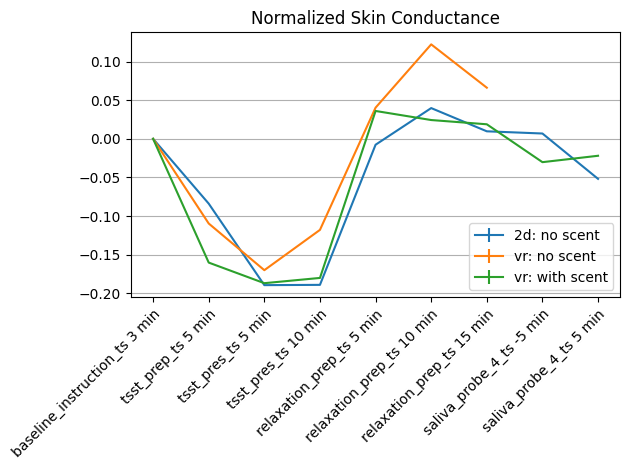

In [383]:
x_pos = np.arange(len(x_labels))
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(hrv_2d_n),  yerr=0, label="2d: no scent" )
ax.errorbar(x_pos,  list(hrv_vr_n),  yerr=0, label="vr: no scent" )
#ax.errorbar(x_pos,  list(hrv_2d_s),  yerr=0, label="2d: with scent")
ax.errorbar(x_pos,  list(hrv_vr_s),  yerr=0, label="vr: with scent")
#ax.set_ylabel(y_label_fig)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
#title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

ax.set_title("Normalized Skin Conductance")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
#plt.ylim(0, 1) 
plt.tight_layout()
plt.show()

In [375]:
hrv_vr_n

array([ 0.        , -0.10961341, -0.1700225 , -0.11785233,  0.04035132,
        0.1222591 ,  0.06617278,         nan,         nan])

In [376]:
no_scent_vr_dict["hrv_mean"]

array([0.39198977, 0.28237636, 0.22196727, 0.27413743, 0.43234109,
       0.51424886, 0.45816255,        nan, 0.36603413])